/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Init train dataset with 460 covid images and 1266 normal images.
Init test dataset with 116 covid images and 317 normal images.


/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


tensor([True])


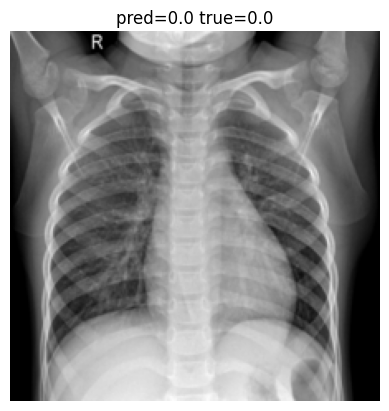

: 

In [ ]:
import datamodule
import models
import saliency
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import BaseConfig
reload(datamodule)
reload(models)
reload(saliency)


def overlay_gradcam_on_image(img_tensor, cam, alpha=0):

    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

config = BaseConfig("./config.json")
dm = datamodule.Datamodule(config)
dm.setup()
dl = dm.test_dataloader()
batch = next(iter(dl))
X, y = batch
# plt.imshow(X.permute(1, 2, 0))
# y = "COVID19" if y else "NORMAL"
# plt.title(f"{y}")
# plt.show()

model = models.BaseCNN.load_from_checkpoint("/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/mn_0.69.ckpt")
model.eval()
pred = model.predict(X)
exit()
gcam = saliency.GradCAM(model.model.cpu())
cam = gcam(X[[0]])
print(pred.view(-1).cpu() == y)
overlay = overlay_gradcam_on_image(X[[0]], cam)
plt.imshow(overlay)
plt.axis('off')
plt.title(f"pred={pred[0].item()} true={y.item()}")
plt.show()

<Axes: >

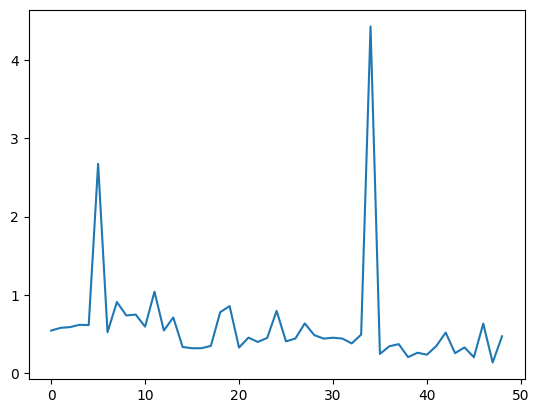

In [1]:
import pandas as pd

ans = pd.read_csv("/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/lightning_logs/version_4/metrics.csv")

ans["train/loss"].plot()

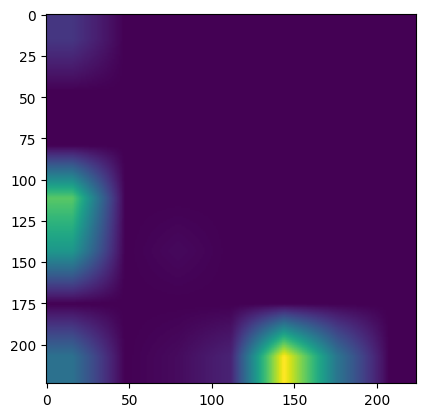

In [6]:
plt.imshow(out)